# Overview

This notebook provides an example usage for using bm3dornl to remove streaks from single sinogram.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

when on a multi-gpu system, make sure specify the card you are using to avoid affecting other people's job

In [2]:
import os

# Set the GPU device ID to 0 for this notebook session
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Prepare synthetic noisy sinogram

In [3]:
from bm3dornl.phantom import (
    shepp_logan_phantom,
    generate_sinogram,
    simulate_detector_gain_error,
)

In [4]:
# define image size
image_size = 512  # smaller size runs faster on local machine, large number means wider image
scan_step = 0.5  # deg, smaller number means taller image
detector_gain_range=(0.97, 1.03)  # variation along detector width
detector_gain_error=0.01  # variation along time/rotation

In [5]:
%%time

# make shepp_logan 2D phantom
shepp_logan_2d = shepp_logan_phantom(
    size=image_size,
    contrast_factor=8,
    )

# transform to sinogram
sino_org, thetas_deg = generate_sinogram(
    input_img=shepp_logan_2d,
    scan_step=scan_step,
    )

# add detector gain error
sino_noisy, detector_gain = simulate_detector_gain_error(
    sinogram=sino_org,
    detector_gain_range=detector_gain_range,
    detector_gain_error=detector_gain_error,
)

CPU times: user 9.04 s, sys: 22.6 ms, total: 9.06 s
Wall time: 9.12 s


visualization

(512, 512) (720, 725) (720, 725)
1e-08 1.0


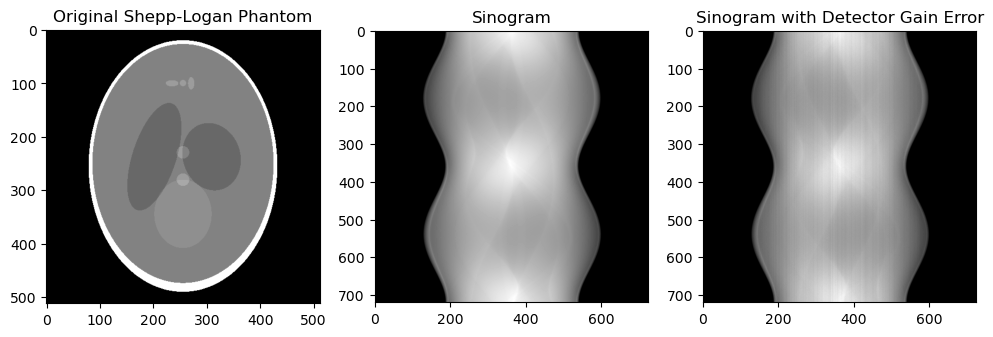

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(shepp_logan_2d, cmap='gray')
ax[0].set_title('Original Shepp-Logan Phantom')
ax[1].imshow(sino_org, cmap='gray')
ax[1].set_title('Sinogram')
ax[2].imshow(sino_noisy, cmap='gray')
ax[2].set_title('Sinogram with Detector Gain Error')

print(shepp_logan_2d.shape, sino_org.shape, sino_noisy.shape)
print(sino_noisy.min(), sino_noisy.max())

estimate background

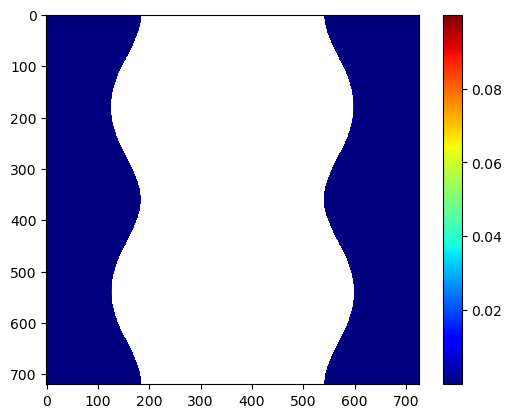

In [7]:
bg_estimate = 0.1

bg = np.array(sino_noisy)
bg[sino_noisy >= bg_estimate] = np.nan
#
plt.imshow(bg, cmap="jet")
plt.colorbar()
plt.show()

## BM3D close source version

In [8]:
import bm3d_streak_removal as bm3dsr

In [9]:
%%timeit

sion_bm3d_attenuated = bm3dsr.extreme_streak_attenuation(
    data=sino_noisy,
    extreme_streak_iterations=3,
    extreme_detect_lambda=4.0,
    extreme_detect_size=9,
    extreme_replace_size=2,
)

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Median fil

In [10]:
# need to have the data
sion_bm3d_attenuated = bm3dsr.extreme_streak_attenuation(
    data=sino_noisy,
    extreme_streak_iterations=3,
    extreme_detect_lambda=4.0,
    extreme_detect_size=9,
    extreme_replace_size=2,
)

Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2


In [11]:
%%timeit

sino_bm3d = bm3dsr.multiscale_streak_removal(
    data=sion_bm3d_attenuated,
    max_bin_iter_horizontal=0,
    bin_vertical=0,
    filter_strength=1.0,
    use_slices=True,
    slice_sizes=None,
    slice_step_sizes=None,
    denoise_indices=None,
)

Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
Denoising sinogram 0
k: 0
55 s ± 2.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
sino_bm3d = bm3dsr.multiscale_streak_removal(
    data=sion_bm3d_attenuated,
    max_bin_iter_horizontal=0,
    bin_vertical=0,
    filter_strength=1.0,
    use_slices=True,
    slice_sizes=None,
    slice_step_sizes=None,
    denoise_indices=None,
)

Denoising sinogram 0
k: 0


In [13]:
sion_bm3d_attenuated = sion_bm3d_attenuated[:, 0, :]
sino_bm3d = sino_bm3d[:, 0, :]

visualization

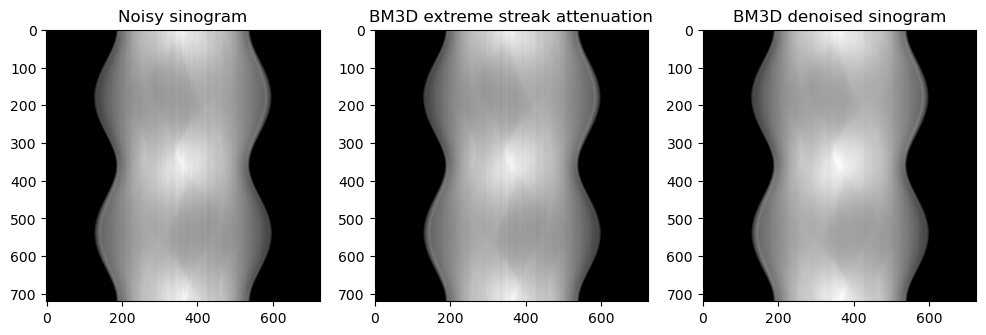

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(sino_noisy, cmap='gray')
axs[0].set_title('Noisy sinogram')
axs[1].imshow(sion_bm3d_attenuated, cmap='gray')
axs[1].set_title('BM3D extreme streak attenuation')
axs[2].imshow(sino_bm3d, cmap='gray')
axs[2].set_title('BM3D denoised sinogram')
plt.show()

## BM3DRONL

In [15]:
from bm3dornl.denoiser import bm3d_ring_artifact_removal
from bm3dornl.gpu_utils import memory_cleanup

In [16]:
memory_cleanup()

In [17]:
keywargs = {
    "patch_size": (8, 8),
    "stride": 3,
    "background_threshold": 1e-3,
    "cut_off_distance": (128, 128),
    "intensity_diff_threshold": 0.2,
    "num_patches_per_group": 300,
    "padding_mode": "circular",
    "gaussian_noise_estimate": 5.0,
    "wiener_filter_strength": 100.0,
}

In [18]:
sino_bm3dornl = bm3d_ring_artifact_removal(
    sinogram=sino_noisy,
    **keywargs,
)

In [19]:
%%timeit

sino_bm3dornl = bm3d_ring_artifact_removal(
    sinogram=sino_noisy,
    **keywargs,
)

7.58 s ± 374 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
from bm3dornl.plot import compute_cdf

val_cap: 0.03563609691276892


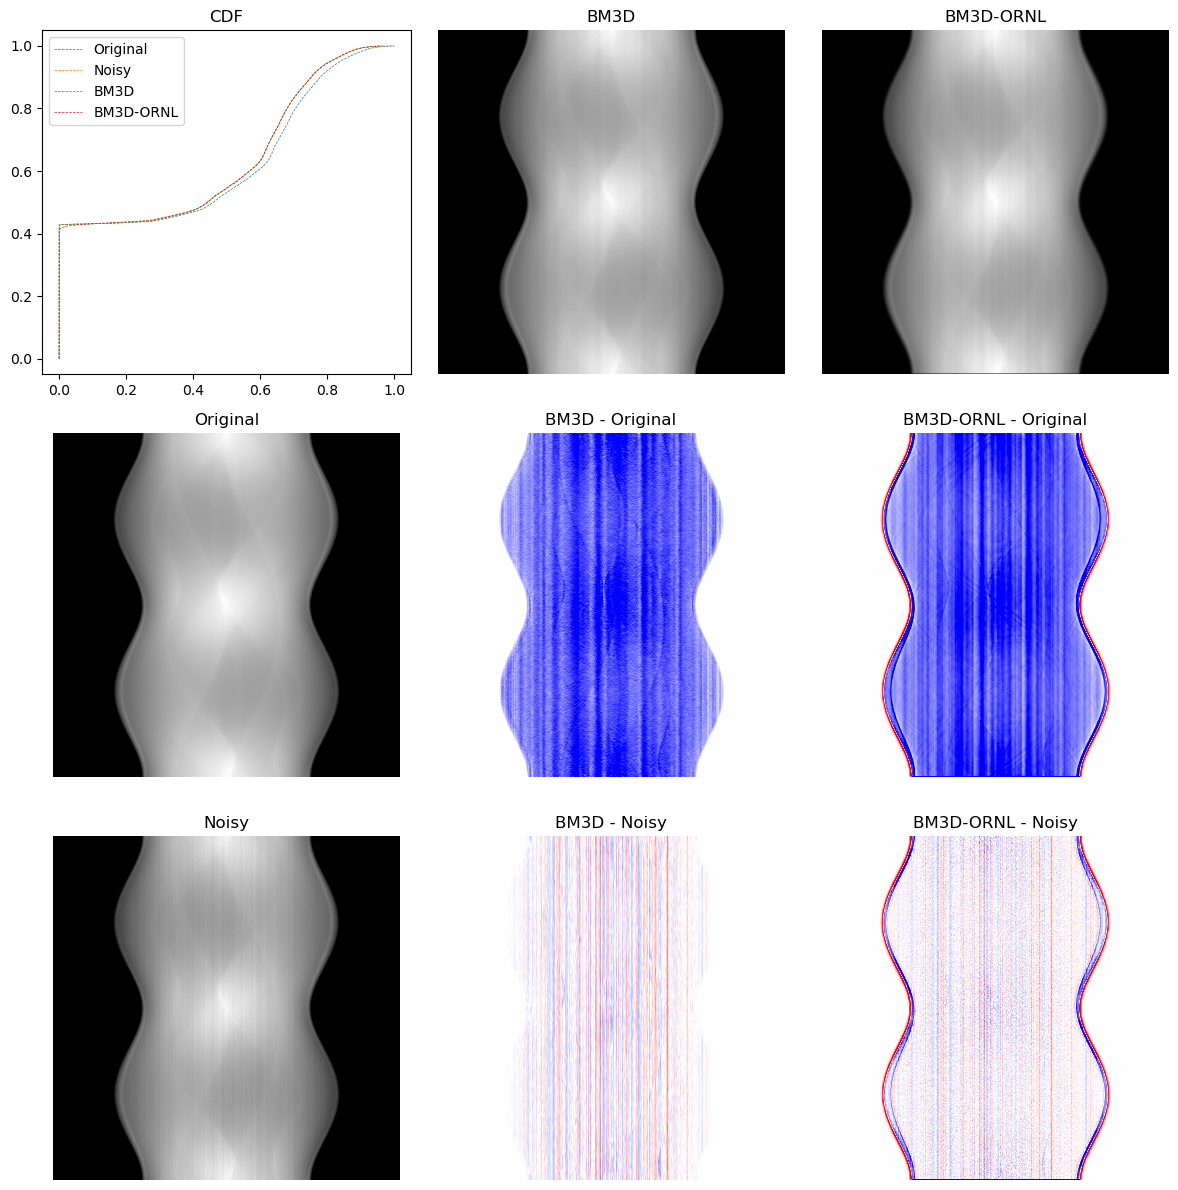

In [21]:
# Visualization of the results
# note: this is a composite visualization for sino_org, sino_noisy, sino_bm3d, and sino_bm3dornl
# ------------------------------------
# top: CDF, bm3d, bm3dornl
# middle: org, bm3d-org, bm3dornl-org
# bottom: noisy, bm3d-noisy, bm3dornl-noisy
# ------------------------------------
# - CDF: Cumulative Distribution Function, including sino_org, sino_noisy, sino_bm3d, and sino_bm3dornl
# - All diff images are using cmap=bwr, and share the same vmin, vmax calculated from bm3d-noisy

fig, axs = plt.subplots(3, 3, figsize=(12, 12))

val_cap = np.absolute(sino_bm3d - sino_noisy).max()

print(f'val_cap: {val_cap}')

# top row
# - CDF
# compute cdf for sino_org, sino_noisy, sino_bm3d, and sino_bm3dornl
# cdf_org
cdf_org_sorted, p_org = compute_cdf(sino_org)
# cdf_noisy
cdf_noisy_sorted, p_noisy = compute_cdf(sino_noisy)
# cdf_bm3d
cdf_bm3d_sorted, p_bm3d = compute_cdf(sino_bm3d)
# cdf_bm3dornl
cdf_bm3dornl_sorted, p_bm3dornl = compute_cdf(sino_bm3dornl)
# plot
axs[0, 0].plot(cdf_org_sorted, p_org, label='Original', linestyle='--', linewidth=0.5)
axs[0, 0].plot(cdf_noisy_sorted, p_noisy, label='Noisy', linestyle='--', linewidth=0.5)
axs[0, 0].plot(cdf_bm3d_sorted, p_bm3d, label='BM3D', linestyle='--', linewidth=0.5)
axs[0, 0].plot(cdf_bm3dornl_sorted, p_bm3dornl, label='BM3D-ORNL', linestyle='--', linewidth=0.5)
axs[0, 0].set_title('CDF')
axs[0, 0].legend()
# - BM3D
axs[0, 1].imshow(sino_bm3d, cmap='gray')
axs[0, 1].set_title('BM3D')
axs[0, 1].axis('off')
# - BM3D-ORNL
axs[0, 2].imshow(sino_bm3dornl, cmap='gray')
axs[0, 2].set_title('BM3D-ORNL')
axs[0, 2].axis('off')

# middle row
# - Original
axs[1, 0].imshow(sino_org, cmap='gray')
axs[1, 0].set_title('Original')
axs[1, 0].axis('off')
# - BM3D - Original
axs[1, 1].imshow(sino_bm3d - sino_org, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[1, 1].set_title('BM3D - Original')
axs[1, 1].axis('off')
# - BM3D-ORNL - Original
axs[1, 2].imshow(sino_bm3dornl - sino_org, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[1, 2].set_title('BM3D-ORNL - Original')
axs[1, 2].axis('off')

# bottom row
# - Noisy
axs[2, 0].imshow(sino_noisy, cmap='gray')
axs[2, 0].set_title('Noisy')
axs[2, 0].axis('off')
# - BM3D - Noisy
axs[2, 1].imshow(sino_bm3d - sino_noisy, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[2, 1].set_title('BM3D - Noisy')
axs[2, 1].axis('off')
# - BM3D-ORNL - Noisy
axs[2, 2].imshow(sino_bm3dornl - sino_noisy, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[2, 2].set_title('BM3D-ORNL - Noisy')
axs[2, 2].axis('off')

fig.tight_layout()
fig.savefig('bm3d_vs_bm3dornl_sino.png')

plt.show()

if `tomopy` is installed, we can also check and compare the reconstruction results 

In [22]:
import tomopy

In [23]:
%%time

kwargs = {
    "center": sino_org.shape[1] / 2,
    "algorithm": 'fbp',
    "filter_name": 'shepp',
}

#
recon_org = tomopy.recon(
    sino_org[:, np.newaxis, :],
    theta=np.deg2rad(thetas_deg),
    **kwargs,
)[0, :, :]

recon_noisy = tomopy.recon(
    sino_noisy[:, np.newaxis, :],
    theta=np.deg2rad(thetas_deg),
    **kwargs,
)[0, :, :]

recon_bm3d = tomopy.recon(
    sino_bm3d[:, np.newaxis, :],
    theta=np.deg2rad(thetas_deg),
    **kwargs,
)[0, :, :]

recon_bm3dornl = tomopy.recon(
    sino_bm3dornl[:, np.newaxis, :],
    theta=np.deg2rad(thetas_deg),
    **kwargs,
)[0, :, :]

CPU times: user 18.8 s, sys: 643 µs, total: 18.8 s
Wall time: 19 s


(-0.5, 724.5, 724.5, -0.5)

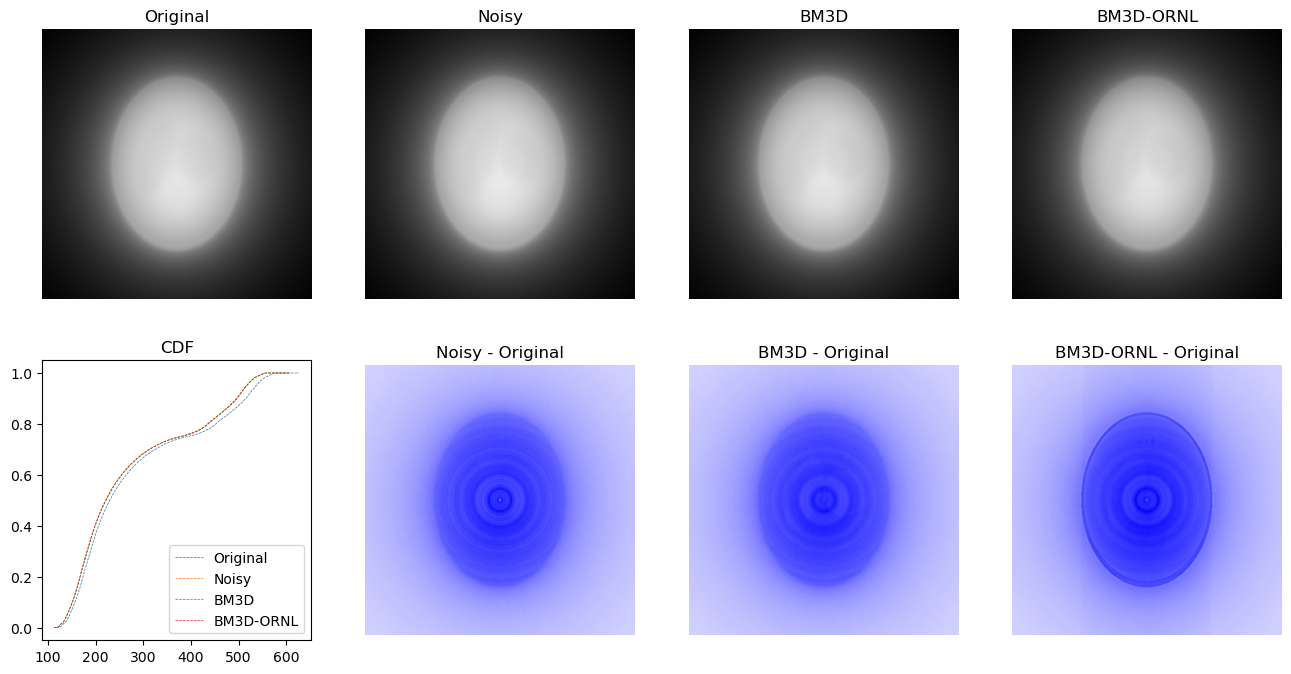

In [24]:
# compare reconstruction results
# top row: org, noisy, bm3d, bm3dornl
# bor row: cdf of all 4, noisy-org, bm3d-org, bm3dornl-org
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

val_cap = np.absolute(recon_bm3dornl - recon_org).max()

# top row
# - Original
axs[0, 0].imshow(recon_org, cmap='gray')
axs[0, 0].set_title('Original')
axs[0, 0].axis('off')
# - Noisy
axs[0, 1].imshow(recon_noisy, cmap='gray')
axs[0, 1].set_title('Noisy')
axs[0, 1].axis('off')
# - BM3D
axs[0, 2].imshow(recon_bm3d, cmap='gray')
axs[0, 2].set_title('BM3D')
axs[0, 2].axis('off')
# - BM3D-ORNL
axs[0, 3].imshow(recon_bm3dornl, cmap='gray')
axs[0, 3].set_title('BM3D-ORNL')
axs[0, 3].axis('off')

# bottom row
# - CDF
# compute cdf for recon_org, recon_noisy, recon_bm3d, and recon_bm3dornl
# cdf_org
cdf_org_sorted, p_org = compute_cdf(recon_org)
# cdf_noisy
cdf_noisy_sorted, p_noisy = compute_cdf(recon_noisy)
# cdf_bm3d
cdf_bm3d_sorted, p_bm3d = compute_cdf(recon_bm3d)
# cdf_bm3dornl
cdf_bm3dornl_sorted, p_bm3dornl = compute_cdf(recon_bm3dornl)
# plot
axs[1, 0].plot(cdf_org_sorted, p_org, label='Original', linestyle='--', linewidth=0.5)
axs[1, 0].plot(cdf_noisy_sorted, p_noisy, label='Noisy', linestyle='--', linewidth=0.5)
axs[1, 0].plot(cdf_bm3d_sorted, p_bm3d, label='BM3D', linestyle='--', linewidth=0.5)
axs[1, 0].plot(cdf_bm3dornl_sorted, p_bm3dornl, label='BM3D-ORNL', linestyle='--', linewidth=0.5)
axs[1, 0].set_title('CDF')
axs[1, 0].legend()
# - Noisy - Original
axs[1, 1].imshow(recon_noisy - recon_org, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[1, 1].set_title('Noisy - Original')
axs[1, 1].axis('off')
# - BM3D - Original
axs[1, 2].imshow(recon_bm3d - recon_org, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[1, 2].set_title('BM3D - Original')
axs[1, 2].axis('off')
# - BM3D-ORNL - Original
axs[1, 3].imshow(recon_bm3dornl - recon_org, cmap='bwr', vmin=-val_cap, vmax=val_cap)
axs[1, 3].set_title('BM3D-ORNL - Original')
axs[1, 3].axis('off')
